In [53]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.utils.data import DataLoader


In [54]:
TRAIN = "../dataset/train"
TEST = "../dataset/test"
transform = Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = ImageFolder(TRAIN, transform)
test_set = ImageFolder(TEST, transform)
train_loader = DataLoader(train_set, shuffle=True)
test_loader = DataLoader(test_set, shuffle=True)


In [55]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 5121
    Root location: ../dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [56]:
print(train_set.classes)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [57]:
print(len(train_loader))

5121


In [58]:
print(test_set)

Dataset ImageFolder
    Number of datapoints: 1279
    Root location: ../dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [59]:
print(test_set.classes)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [60]:
print(len(test_loader))

1279


In [61]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

IndexError: index 1 is out of bounds for dimension 0 with size 1

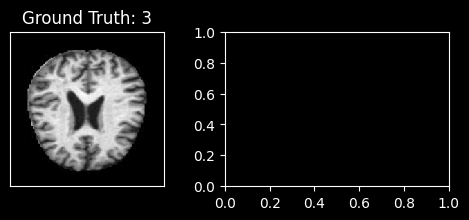

In [62]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


In [ ]:
arr=[
        [
            [10,20,2,4], 
            [7,30,3,40]
        ],
        [
            [9,50,60,5], 
            [4,70,5,80]
        ],
        [
            [19,5,60,9], 
            [14,7,80,1]
        ]
    ]
arr=np.array(arr)
print(arr.shape)

(3, 2, 4)


In [ ]:
for i in arr:
    print(i.shape)

(2, 4)
(2, 4)
(2, 4)


In [ ]:
input_size = 90000
hidden_sizes = [9000, 900, 90]
output_size = 4
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), nn.Sigmoid(), nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.Tanh(), nn.Linear(hidden_sizes[1], hidden_sizes[2]), nn.LeakyReLU(), nn.Linear(hidden_sizes[2], output_size), nn.ReLU())
print(model)


Sequential(
  (0): Linear(in_features=90000, out_features=9000, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9000, out_features=900, bias=True)
  (3): Tanh()
  (4): Linear(in_features=900, out_features=90, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=90, out_features=4, bias=True)
  (7): ReLU()
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logps = model(images)  # log probabilities
loss = criterion(logps, labels)  # calculate the NLL loss

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
        print("\nTraining Time (in minutes) =",(time()-time0)/60)


RuntimeError: Found dtype Long but expected Float

In [ ]:


def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(img.resize_(208, 176, 1).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()


In [ ]:
images, labels = next(iter(test_loader))

img = images[0].view(1, 109824)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(3, 208, 176), ps)


RuntimeError: shape '[1, 109824]' is invalid for input of size 90000

In [ ]:
correct_count, all_count = 0, 0
for images, labels in test_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 109824)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if (true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))


Number Of Images Tested = 1279

Model Accuracy = 0.5215011727912432
